In [1]:
import os
from glob import glob

import numpy as np
from matplotlib import pyplot as plt

import pyart

import radar_codes
import attenuation
import rainrate


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#files to process
derived_path = '/g/data/hj10/cp2/level_1/derived/sur/2014/20141127'
level_1b_path = '/g/data/hj10/admin/cp2/cp2_level_1b/v2020/ppi/2014/20141127'
vol_ffn_list = sorted(glob(level_1b_path + '/*.nc'))

#init alpha dict
alpha_dict = {'z_pairs':[], 'zdr_pairs':[], 'alpha_ts':[0.015], 'dt_ts':[]}

#process single file
vol_ffn = vol_ffn_list[64] #peak intensity around 64
print('processing', vol_ffn)

#read radar
radar = pyart.io.read(vol_ffn, file_field_names=True)

#Temperature    
height, temperature, isom = radar_codes.temperature_profile_access(radar, source='era5')
radar.add_field('temperature', temperature, replace_existing=True)
radar.add_field('height', height, replace_existing=True)
radar.add_field('height_over_isom', isom, replace_existing=True)

#generate gatefilter for nonprecip
#radar = common.add_ncar_pid(radar, derived_path, vol_ffn)

#estimate alpha
alpha, alpha_method = attenuation.estimate_alpha_zhang2020(radar, 'S', 0,
                                       refl_field='reflectivity', zdr_field='differential_reflectivity', rhohv_field='cross_correlation_ratio',
                                       verbose=True)
print(alpha)

processing /g/data/hj10/admin/cp2/cp2_level_1b/v2020/ppi/2014/20141127/501_20141127_062402_level1b_ppi.nc
defaults 0.020680899138540435 0.035791610415545835


case 1 valid bins 16
case 1 thresholds 8
case 1a valid bins 5
case 1a thresholds 3
case 2 valid bins 11
case 2 thresholds 11
case 3 valid bins 16
case 3 thresholds 9
case 4 True
case 4 total count 2880.0
case 4 min 50

1: fitted 20-50dbZ
alpha value 0.020680899138540435
0.020680899138540435


In [3]:
from skimage import morphology
from scipy.integrate import cumtrapz

alpha=0.015
beta=0.62

smooth_window_len=5
refl_field='reflectivity'
phidp_field='corrected_differential_phase'
rhohv_field='cross_correlation_ratio'

# extract fields and parameters from radar if they exist
# reflectivity and differential phase must exist
# create array to hold the output data
radar.check_field_exists(refl_field)
refl = radar.fields[refl_field]['data'].copy()
radar.check_field_exists(phidp_field)
phidp = radar.fields[phidp_field]['data'].copy()
radar.check_field_exists(rhohv_field)
rhohv = radar.fields[rhohv_field]['data'].copy()

ah = np.ma.zeros(refl.shape, dtype='float64')

#smooth reflectivity
sm_refl = attenuation._smooth_masked(refl, wind_len=smooth_window_len,
                        min_valid=1, wind_type='mean')

radar.add_field_like('reflectivity', 'sm_reflectivity', sm_refl, replace_existing=True)

In [4]:
#load gatefilter
gatefilter = pyart.correct.GateFilter(radar)

#mask clutter
pid = radar.fields['radar_echo_classification']['data']
gatefilter.exclude_gates(np.ma.getmask(pid))
#mask hail
gatefilter.exclude_gates(pid==9)
#mask data above melting level
isom = radar.fields['height_over_isom']['data']
gatefilter.exclude_gates(isom > 0)

#create rhohv and z mask for determining r1 and r2
edge_mask = np.logical_or(rhohv.filled(fill_value=0) < 0.98, sm_refl.filled(fill_value=0) < 5)

#despeckle gatefilter
valid_mask = gatefilter.gate_included
valid_mask_filt = morphology.remove_small_holes(valid_mask, area_threshold=10)
valid_mask_filt = morphology.remove_small_objects(valid_mask_filt, min_size=10)
gatefilter.include_gates(valid_mask_filt)

(-25.0, 25.0)

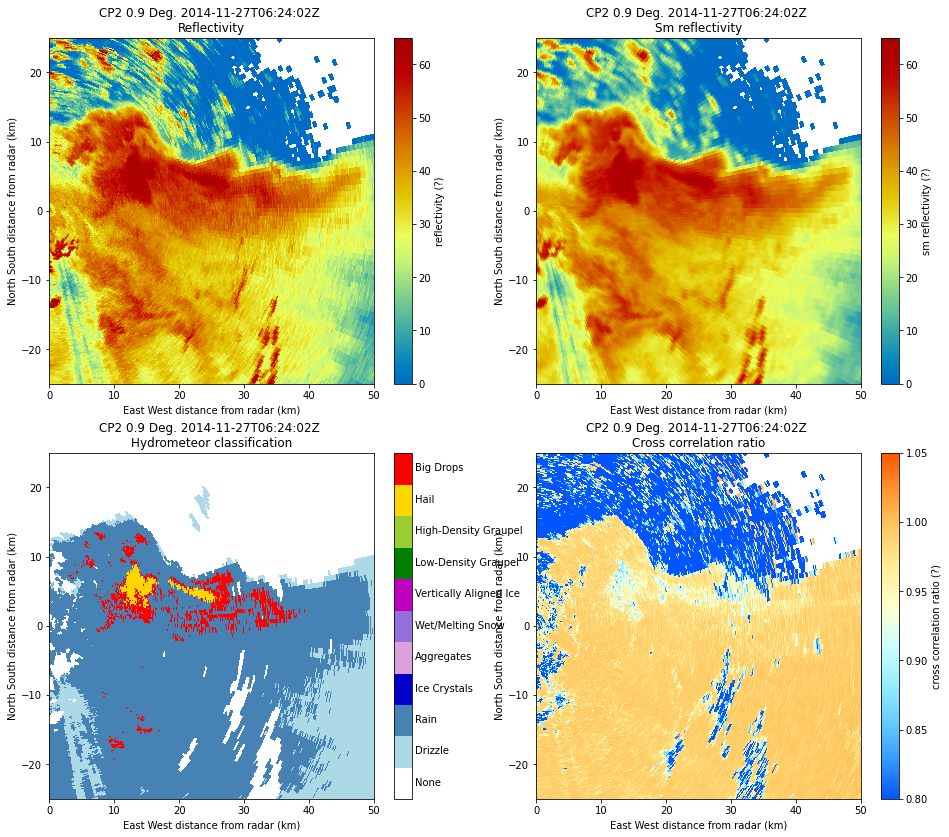

In [5]:
import matplotlib.colors as colors

tilt = 0
ylim = [-25, 25]
xlim = [0, 50]
def _adjust_csu_scheme_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(.55, 11, 1))
    cb.ax.set_yticklabels(['None','Drizzle','Rain',
                           'Ice Crystals','Aggregates','Wet/Melting Snow','Vertically Aligned Ice',
                           'Low-Density Graupel','High-Density Graupel',
                           'Hail',
                           'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def _adjust_ncar_scheme_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(.25, 18, 1))
    cb.ax.set_yticklabels(['Cloud',
                           'Drizzle', 'Light_Rain', 'Moderate_Rain', 'Heavy_Rain',
                            'Hail', 'Rain_Hail_Mixture',
                            'Graupel_Small_Hail', 'Graupel_Rain',
                            'Dry_Snow', 'Wet_Snow', 'Ice_Crystals', 'Irreg_Ice_Crystals', 'Supercooled_Liquid_Droplets',
                            'Flying_Insects', 'Second_trip', 'Ground_Clutter', 'Receiver saturation'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

hca_colors = ['White', 'LightBlue', 'SteelBlue', 'MediumBlue',
      'Plum','MediumPurple','m',
      'Green','YellowGreen',
      'Gold',
      'Red']
hca_cmap = colors.ListedColormap(hca_colors)

ncar_colors = ['lightseagreen',
               'LightBlue', 'SteelBlue', 'MediumBlue', 'DarkBlue',
      'Red','DarkRed',
      'MediumPurple','m',
      'Green','YellowGreen','lightgreen','cyan','lime',
      'dimgray','darkgray','lightgray','lightcoral']
ncar_cmap = colors.ListedColormap(ncar_colors)

fig = plt.figure(figsize=[16,14])
display = pyart.graph.RadarDisplay(radar)

ax = plt.subplot(221)
display.plot_ppi('reflectivity', tilt, vmin=0, vmax=65, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(222)
display.plot_ppi('sm_reflectivity', tilt, vmin=0, vmax=65, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(223)
display.plot_ppi('radar_echo_classification', tilt, cmap=hca_cmap, vmin=0, vmax=11)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
display.cbs[2] = _adjust_csu_scheme_colorbar_for_pyart(display.cbs[2])

ax = plt.subplot(224)
display.plot_ppi('cross_correlation_ratio', tilt, vmin=0.8, cmap='pyart_BuOr10')
ax.set_xlim(xlim)
ax.set_ylim(ylim)




(-25.0, 25.0)

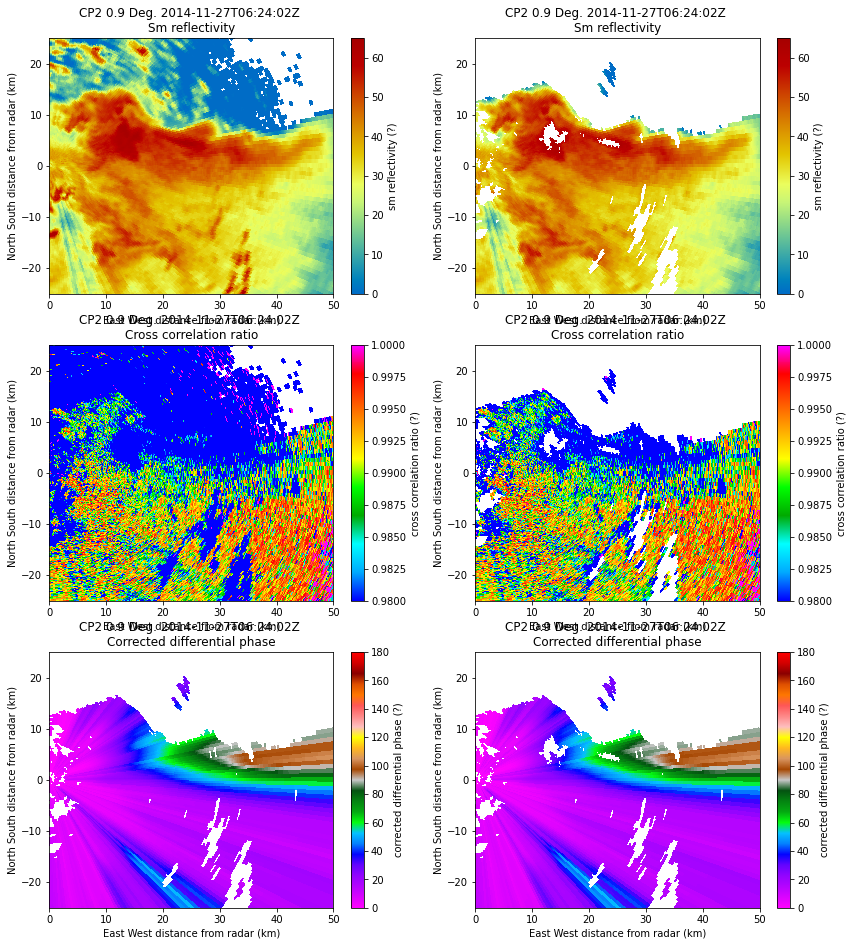

In [6]:
tilt = 0
ylim = [-25, 25]
xlim = [0, 50]

fig = plt.figure(figsize=[14,16])
display = pyart.graph.RadarDisplay(radar)

ax = plt.subplot(321)
display.plot_ppi('sm_reflectivity', tilt, vmin=0, vmax=65, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(322)
display.plot_ppi('sm_reflectivity', tilt, gatefilter=gatefilter, vmin=0, vmax=65, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(323)
display.plot_ppi('cross_correlation_ratio', tilt, vmin=0.98, vmax=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(324)
display.plot_ppi('cross_correlation_ratio', tilt, gatefilter=gatefilter, vmin=0.98, vmax=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(325)
display.plot_ppi('corrected_differential_phase', tilt, cmap='pyart_Wild25', vmin=0, vmax=180)
ax.set_xlim(xlim)
ax.set_ylim(ylim)


ax = plt.subplot(326)
display.plot_ppi('corrected_differential_phase', tilt, cmap='pyart_Wild25', vmin=0, vmax=180, gatefilter=gatefilter)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

<ipython-input-7-68c0375ca211>:29: UserWarning: Warning: converting a masked element to nan.
  end_gate_phidp[ray] = corr_phidp[ray, ind_rng[-1]-1]
<ipython-input-7-68c0375ca211>:30: UserWarning: Warning: converting a masked element to nan.
  start_gate_phidp[ray] = corr_phidp[ray, ind_rng[0]]


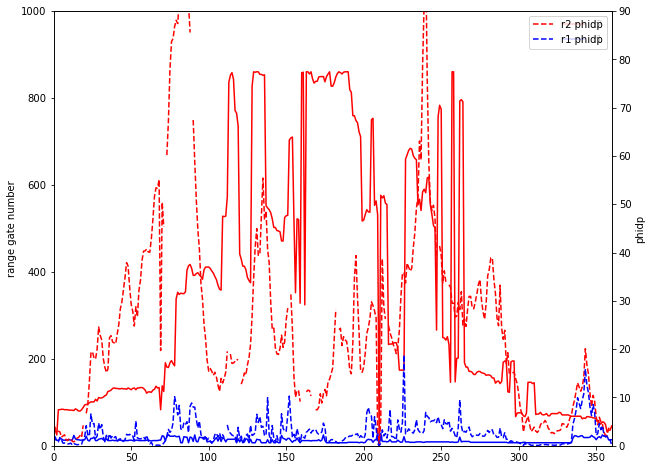

In [7]:
#prepare phidp by applying mask directly
mask_phidp = np.ma.getmaskarray(phidp)
mask_phidp = np.logical_and(mask_phidp, ~valid_mask_filt)
corr_phidp = np.ma.masked_where(mask_phidp, phidp)

#convert refl to z and gate spacing (in km)
refl_linear = np.ma.power(10.0, 0.1 * beta * sm_refl).filled(fill_value=0)
dr = (radar.range['data'][1] - radar.range['data'][0]) / 1000.0

#find end indicies in reject_mask
end_gate_arr = np.zeros(radar.nrays, dtype='int32')
start_gate_arr = np.zeros(radar.nrays, dtype='int32')
end_gate_phidp = np.zeros(radar.nrays)
start_gate_phidp = np.zeros(radar.nrays)

#combine edge + gatefilter
valid_mask = np.logical_and(gatefilter.gate_included, ~edge_mask)

for ray in range(radar.nrays):
    ind_rng = np.where(valid_mask[ray, :] == 1)[0]
    if len(ind_rng) > 1:
        #CP2 experences invalid data in the first 5 gates. ignore these gates
        ind_rng = ind_rng[ind_rng>6]
    if len(ind_rng) > 1:
        # there are filtered gates: The last valid gate is one
        # before the first filter gate
        end_gate_arr[ray] = ind_rng[-1]-1 #ensures that index is -1 if all rays are masked
        start_gate_arr[ray] = ind_rng[0]
        end_gate_phidp[ray] = corr_phidp[ray, ind_rng[-1]-1]
        start_gate_phidp[ray] = corr_phidp[ray, ind_rng[0]]
        
fig, ax = plt.subplots(1,1, figsize=[10,8])  
ax2 = ax.twinx()
ax.plot(end_gate_arr,'r-', label='r2')
ax.plot(start_gate_arr,'b-', label='r1')
ax2.plot(end_gate_phidp,'r--', label='r2 phidp')
ax2.plot(start_gate_phidp,'b--', label='r1 phidp')
ax.legend()
ax.set_xlim([0,360])
ax.set_ylim([0,1000])
ax.set_ylabel('range gate number')
ax2.set_ylim([0,90])
ax2.set_ylabel('phidp')
ax2.legend()



/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.8/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(-25.0, 25.0)

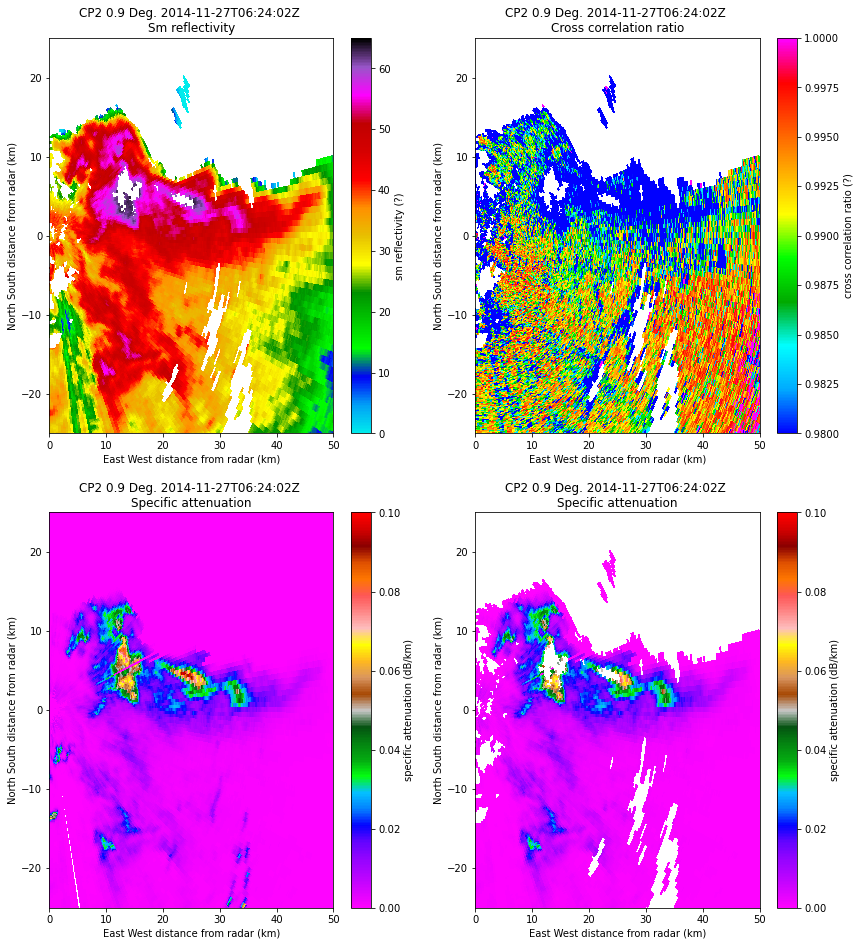

In [8]:
for ray in range(radar.nrays):
    # perform attenuation calculation on a single ray

    # if number of valid range bins larger than smoothing window
    if end_gate_arr[ray]-start_gate_arr[ray] > smooth_window_len:
        # extract the ray's phase shift,
        # init. refl. correction and mask
        ray_phase_shift = corr_phidp[ray, start_gate_arr[ray]:end_gate_arr[ray]]
        ray_mask = valid_mask_filt[ray, start_gate_arr[ray]:end_gate_arr[ray]]
        ray_refl_linear = refl_linear[ray, start_gate_arr[ray]:end_gate_arr[ray]]

        # perform calculation if there is valid data
        last_six_good = np.where(np.ndarray.flatten(ray_mask) == 1)[0][-6:]
        if(len(last_six_good)) == 6:
            phidp_max = np.median(ray_phase_shift[last_six_good])
            self_cons_number = (
                np.exp(0.23 * beta * alpha * phidp_max) - 1.0)
            I_indef = cumtrapz(0.46 * beta * dr * ray_refl_linear[::-1])
            I_indef = np.append(I_indef, I_indef[-1])[::-1]

            # set the specific attenutation and attenuation
            ah[ray, start_gate_arr[ray]:end_gate_arr[ray]] = (
                ray_refl_linear * self_cons_number /
                (I_indef[0] + self_cons_number * I_indef))
            
#add ah into radar
spec_at = pyart.config.get_metadata('specific_attenuation')
temp_array = np.ma.masked_where(gatefilter.gate_excluded, ah)
spec_at['data'] = ah
spec_at['_FillValue'] = ah.fill_value
radar.add_field('specific_attenuation_cp2', spec_at, replace_existing=True)


radar = attenuation.retrieve_zphi(radar, 'S', alpha=alpha, alpha_method=alpha_method,
                                 refl_field='reflectivity', phidp_field='corrected_differential_phase', rhohv_field='cross_correlation_ratio')

tilt = 0
ylim = [-25, 25]
xlim = [0, 50]

fig = plt.figure(figsize=[14,16])
display = pyart.graph.RadarDisplay(radar)

ax = plt.subplot(221)
display.plot_ppi('sm_reflectivity', tilt, cmap='pyart_NWSRef', vmin=0, vmax=65, gatefilter=gatefilter)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(222)
display.plot_ppi('cross_correlation_ratio', tilt, vmin=0.98, vmax=1, gatefilter=gatefilter)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# ax = plt.subplot(223)
# display.plot_ppi('corrected_differential_phase', tilt, cmap='pyart_Wild25', vmin=0, vmax=180, gatefilter=gatefilter)
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

ax = plt.subplot(223)
display.plot_ppi('specific_attenuation_cp2', tilt, cmap='pyart_Wild25', vmax=0.1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(224)
display.plot_ppi('specific_attenuation', tilt, cmap='pyart_Wild25', vmax=0.1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

(-25.0, 25.0)

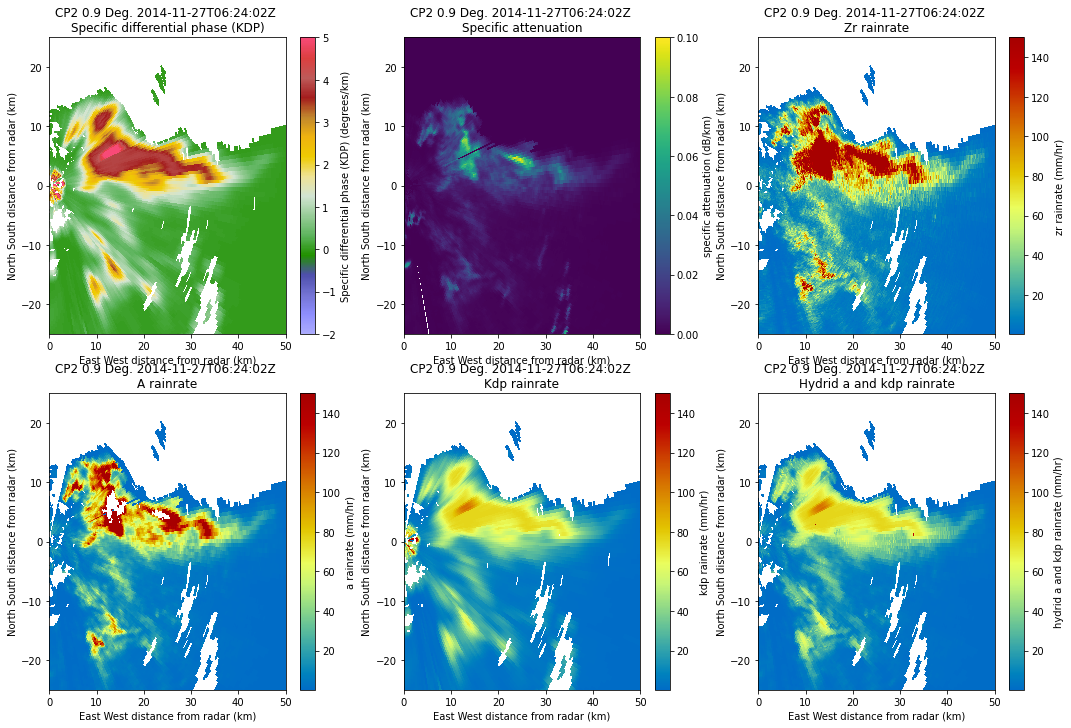

In [9]:
#generate standard zr relationship

radar = rainrate.conventional(radar, alpha=92, beta=1.7, refl_field='corrected_reflectivity')
radar = rainrate.polarimetric(radar, 'S', refl_field='corrected_reflectivity',
                              kdp_field='corrected_specific_differential_phase', phidp_field='corrected_differential_phase', 
                              rhohv_field='cross_correlation_ratio',
                             refl_lower_threshold=45., refl_upper_threshold=50.)

# #get kdp
# kdp = radar.fields['corrected_specific_differential_phase']['data']
# #create rain and hail masks
# hail_mask = sm_refl>50#pid==9

# full_rain = np.ma.zeros(ah.shape, dtype='float64')
# ah_rain = np.ma.zeros(ah.shape, dtype='float64')
# kdp_rain = np.ma.zeros(ah.shape, dtype='float64')

# ah_rain = 4120*(ah**1.03)
# kdp_rain = 27*(kdp**0.77)

# full_rain = ah_rain.copy()
# full_rain[hail_mask] = kdp_rain[hail_mask]

# radar.add_field_like('z_rain', 'ah-kdp_rain', full_rain, replace_existing=True)
# radar.add_field_like('z_rain', 'ah_rain', ah_rain, replace_existing=True)
# radar.add_field_like('z_rain', 'kdp_rain', kdp_rain, replace_existing=True)
# radar.fields['z_rain']['standard_name'] = 'Rainrate from R(Z)'
# radar.fields['ah-kdp_rain']['standard_name'] = 'Rainrate from R(A) and R(kdp)'
# radar.fields['ah_rain']['standard_name'] = 'Rainrate from R(A)'
# radar.fields['kdp_rain']['standard_name'] = 'Rainrate from R(kdp)'




tilt = 0
ylim = [-25, 25]
xlim = [0, 50]

fig = plt.figure(figsize=[18,12])
ax = plt.subplot(231)
display.plot_ppi('corrected_specific_differential_phase', tilt)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(232)
display.plot_ppi('specific_attenuation_cp2', tilt, vmin=0, vmax=0.1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

#restore hail pixels
gatefilter.include_gates(pid==9)

ax = plt.subplot(233)
display.plot_ppi('zr_rainrate', tilt, vmin=0.2, vmax=150, gatefilter=gatefilter, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(234)
display.plot_ppi('ah_rainrate', tilt, vmin=0.2, vmax=150, gatefilter=gatefilter, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(235)
display.plot_ppi('kdp_rainrate', tilt, vmin=0.2, vmax=150, gatefilter=gatefilter, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(236)
display.plot_ppi('hybrid_rainrate', tilt, vmin=0.2, vmax=150, gatefilter=gatefilter, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [48]:
#todo:
#create line plot
#clean up this notebook as an explore notebook, restore original retrieval notebook, move changed to specific_atten.py

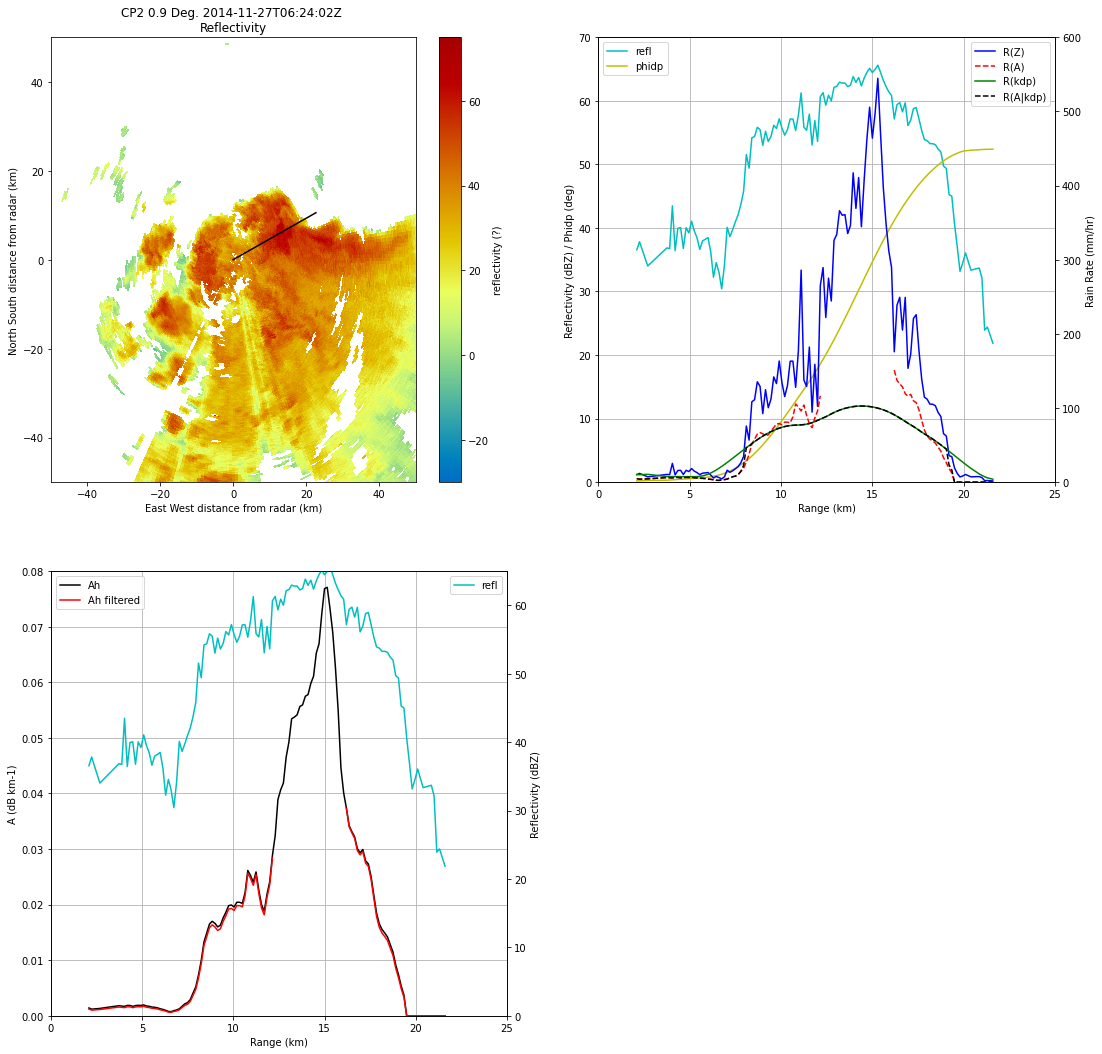

In [17]:
def plot_cross_hair(size, angle, npts=100, ax=None):
    """
    Plot a cross-hair on a ppi plot.

    Parameters
    ----------
    size : float
        Size of cross-hair in km.
    npts: int
        Number of points in the cross-hair, higher for better resolution.
    ax : Axis
        Axis to plot on. None will use the current axis.

    """    
    #angle = angle.to('radians').m
        
    r = np.linspace(0, size, npts)
    
    x = r*np.sin(np.radians(angle))
    y = r*np.cos(np.radians(angle))
    
    ax.plot(x, y, 'k-')  # verticle


rhi_angle = 65
range_limit = 25
tilt_idx = 0
ylim = [-50, 50]
xlim = [-50, 50]

#plot reflectivity PPI
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[18,18])
ax = plt.subplot(221)
display.plot_ppi('reflectivity', tilt_idx, gatefilter=gatefilter)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plot_cross_hair(range_limit, rhi_angle, npts=100, ax=ax)

#extract rhi at azimuth
rhi_data = pyart.util.cross_section_ppi(radar, [rhi_angle])
range_array = rhi_data.range['data']/1000
range_mask = np.logical_and(range_array>2, range_array<range_limit)
hca_ray = rhi_data.fields['radar_echo_classification']['data'][tilt_idx,:]
hca_mask = np.ma.getmask(hca_ray)
valid_mask = np.logical_and(range_mask, ~hca_mask)

#plot refl/phidp
refl_ray = rhi_data.fields['reflectivity']['data'][tilt_idx,:]
phidp_ray = rhi_data.fields['corrected_differential_phase']['data'][tilt_idx,:]
ah_ray = rhi_data.fields['specific_attenuation']['data'][tilt_idx,:]
ah_cp2_ray = rhi_data.fields['specific_attenuation_cp2']['data'][tilt_idx,:]

rain_z_ray = rhi_data.fields['zr_rainrate']['data'][tilt_idx,:]
rain_ah_ray = rhi_data.fields['ah_rainrate']['data'][tilt_idx,:]
rain_kdp_ray = rhi_data.fields['kdp_rainrate']['data'][tilt_idx,:]
rain_ah_kdp_ray = rhi_data.fields['hybrid_rainrate']['data'][tilt_idx,:]

ax = plt.subplot(222)
ax2 = ax.twinx()
ax.plot(range_array[valid_mask], refl_ray[valid_mask], 'c-', label='refl')
ax.plot(range_array[valid_mask], phidp_ray[valid_mask], 'y-', label='phidp')

ax2.plot(range_array[valid_mask], rain_z_ray[valid_mask], 'b-', label='R(Z)')
ax2.plot(range_array[valid_mask], rain_ah_ray[valid_mask], 'r--', label='R(A)')
ax2.plot(range_array[valid_mask], rain_kdp_ray[valid_mask], 'g-', label='R(kdp)')
ax2.plot(range_array[valid_mask], rain_ah_kdp_ray[valid_mask], 'k--', label='R(A|kdp)')
ax.set_ylabel('Reflectivity (dBZ) / Phidp (deg)')
ax.set_xlim([0,25])
ax.set_ylim([0,70])
ax2.set_ylim([0,600])
ax.grid()
ax2.set_ylabel('Rain Rate (mm/hr)')
ax.set_xlabel('Range (km)')
ax.legend(loc='upper left')
ax2.legend()


ax = plt.subplot(223)
ax2 = ax.twinx()
ax.plot(range_array[valid_mask], ah_cp2_ray[valid_mask], 'k-', label='Ah')
ax.plot(range_array[valid_mask], ah_ray[valid_mask], 'r-', label='Ah filtered')
ax2.plot(range_array[valid_mask], refl_ray[valid_mask], 'c-', label='refl')
ax.set_ylabel('A (dB km-1)')
ax2.set_ylabel('Reflectivity (dBZ)')
ax.set_xlim([0,25])
ax.set_ylim([0,0.08])
ax2.set_ylim([0,65])
ax.grid()
ax.set_xlabel('Range (km)')
ax.legend(loc='upper left')
ax2.legend()

#plot rainfall


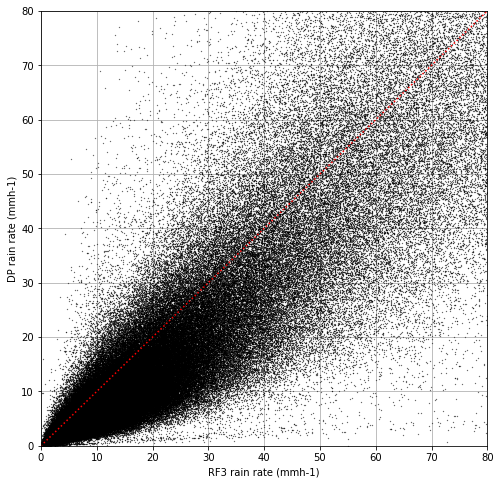

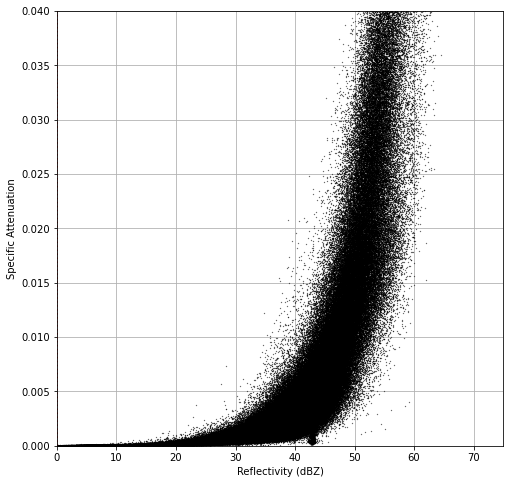

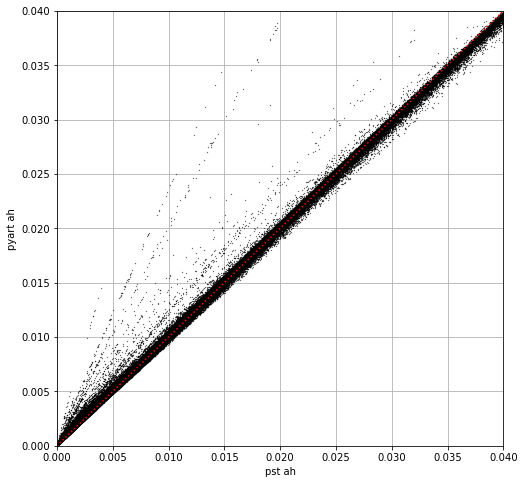

In [61]:
plt.figure(figsize=[8,8])

x_val = radar.fields['z_rain']['data'].flatten()
y_val = radar.fields['ah_rain']['data'].flatten()
filt = np.logical_and(x_val>0, y_val>0)
x_val = x_val[filt]
y_val = y_val[filt]

plt.plot(x_val, y_val, 'k.', ms=0.5)
plt.xlim([0, 80])
plt.ylim([0, 80])
plt.xlabel('RF3 rain rate (mmh-1)')
plt.ylabel('DP rain rate (mmh-1)')
plt.grid()
plt.plot([0,80],[0,80],'r:')

plt.figure(figsize=[8,8])

x_val = radar.fields['reflectivity']['data'].flatten()
y_val = radar.fields['specific_attenuation']['data'].flatten()
filt = np.logical_and(x_val>0, y_val>0)
x_val = x_val[filt]
y_val = y_val[filt]

plt.plot(x_val, y_val, 'k.', ms=0.5)
plt.xlim([0, 75])
plt.ylim([0, 0.04])
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Specific Attenuation')
plt.grid()
plt.plot([0,0.04],[0,80],'r:')



plt.figure(figsize=[8,8])

x_val = radar.fields['specific_attenuation']['data'].flatten()
y_val = radar.fields['specific_attenuation_cp2']['data'].flatten()
filt = np.logical_and(x_val>0, y_val>0)
x_val = x_val[filt]
y_val = y_val[filt]

plt.plot(x_val, y_val, 'k.', ms=0.5)
plt.xlim([0, 0.04])
plt.ylim([0, 0.04])
plt.xlabel('pst ah')
plt.ylabel('pyart ah')
plt.grid()
plt.plot([0,0.04],[0,0.04],'r:')